In [1]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from datetime import datetime,timedelta
import matplotlib.dates as mdates
import sys 
import csv

from utils import *

country_iso_3 = sys.argv[1]

ASSESSMENT_DATE='2020-09-23'
# TODAY = date.today()
TODAY = datetime.strptime(ASSESSMENT_DATE, '%Y-%m-%d').date()
FOUR_WEEKS = TODAY + timedelta(days=28)
TWO_WEEKS = TODAY + timedelta(days=14)
LAST_TWO_MONTHS = TODAY - timedelta(days=60)
EARLIEST_DATE = datetime.strptime('2020-02-24', '%Y-%m-%d').date()

MIN_QUANTILE=0.25
MAX_QUANTILE=0.75
# MIN_QUANTILE=0.05
# MAX_QUANTILE=0.95

CONFIG_FILE = 'config.yml'
DIR_PATH = ""#os.path.dirname(os.path.realpath(__file__))
WHO_COVID_URL='https://covid19.who.int/WHO-COVID-19-global-data.csv'
WHO_COVID_FILENAME='WHO_data/WHO-COVID-19-global-data.csv'
RESULTS_FILENAME=f'automated_reports/report_metrics/{country_iso_3}_results.csv'

NPI_COLOR='green'
NO_NPI_COLOR='red'
WHO_DATA_COLOR='dodgerblue'
SUBNATIONAL_DATA_COLOR='navy'

In [2]:
country_iso3="SDN"# AFG SSD SDN COD SOM IRQ
parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
#     if download_covid:
#         # Download latest covid file tiles and read them in
#         download_who_covid_data(WHO_COVID_URL,f'{DIR_PATH}/{WHO_COVID_FILENAME}')
set_matlotlib(plt)
# print('\n\n\n')
# print(f'{country_iso3}')

In [3]:
from mapclassify import UserDefined
import mapclassify as mc

In [4]:
bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
bucky_npi_proj = bucky_npi.loc[TWO_WEEKS,:]
bucky_npi_tod=bucky_npi.loc[TODAY,:]

In [5]:
who_covid=get_who(WHO_COVID_FILENAME,parameters['iso2_code'],min_date=LAST_TWO_MONTHS,max_date=FOUR_WEEKS)
who_deaths_today=who_covid.loc[TODAY,'Cumulative_deaths']
who_cases_today=who_covid.loc[TODAY,'Cumulative_cases']    
CFR=who_deaths_today/who_cases_today*100
# get weekly new cases
who_covid.index = pd.to_datetime(who_covid.index)
new_WHO_w=who_covid.groupby(['Country_code']).resample('W').sum()[['New_cases','New_deaths']]
ndays_w=who_covid.groupby(['Country_code']).resample('W').count()['New_cases']
ndays_w=ndays_w.rename('ndays')
new_WHO_w=pd.merge(left=new_WHO_w,right=ndays_w,left_index=True,right_index=True,how='inner')
new_WHO_w=new_WHO_w[new_WHO_w['ndays']==7]
new_WHO_w['New_cases_PercentChange'] = new_WHO_w.groupby('Country_code')['New_cases'].pct_change()
new_WHO_w['New_deaths_PercentChange'] = new_WHO_w.groupby('Country_code')['New_deaths'].pct_change()

In [6]:
ndays_w

Country_code  Date_reported
SD            2020-07-26       2
              2020-08-02       7
              2020-08-09       7
              2020-08-16       7
              2020-08-23       7
              2020-08-30       7
              2020-09-06       7
              2020-09-13       7
              2020-09-20       7
              2020-09-27       3
Name: ndays, dtype: int64

In [7]:
bucky_npi

,adm1,cases_per_100k
date,,
2020-09-23,1,76.420731
2020-09-24,1,76.972954
2020-09-25,1,77.249532
2020-09-26,1,77.990688
2020-09-27,1,78.960796
...,...,...
2020-10-03,19,0.000000
2020-10-04,19,0.000000
2020-10-05,19,0.000000


In [8]:
bucky_npi_ct=bucky_npi.loc[TWO_WEEKS,:]
# bucky_npi_ct["change_cases_100k"]=
bucky_npi_change=bucky_npi.loc[bucky_npi.index.isin([TODAY,TWO_WEEKS]),:].groupby("adm1")["cases_per_100k"].pct_change().replace(np.nan,0)[TWO_WEEKS]
bucky_npi_change_t=bucky_npi_change.loc[TWO_WEEKS]
# buckky_npi_change=pd.DataFrame(bucky_npi_change)
# bucky_npi_ct=bucky_npi_change[TWO_WEEKS].replace(np.nan,0)
# bucky_npi_changet.columns=["change"]

In [9]:
bucky_npi_change

2020-10-07    0.121067
2020-10-07    0.941176
2020-10-07    0.000000
2020-10-07    0.018136
2020-10-07    0.000000
2020-10-07    0.966102
2020-10-07    0.922330
2020-10-07    0.000000
2020-10-07    1.059229
2020-10-07   -0.004871
2020-10-07    0.861744
2020-10-07    0.057711
2020-10-07    0.029770
2020-10-07    1.032520
2020-10-07    0.304212
2020-10-07    0.041050
2020-10-07   -0.014403
2020-10-07    0.895349
2020-10-07    0.000000
Name: cases_per_100k, dtype: float64

In [10]:
bucky_npi_ct["bla"]=bucky_npi_change_t.values

<ipython-input-10-ca2bc0d93f15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bucky_npi_ct["bla"]=bucky_npi_change_t.values


In [11]:
len(bucky_npi_change.values)

19

In [12]:
# bucky_npi_ct=bucky_npi_ct.to_frame(name="change_cases_100k")

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [ ]:
# bucky_npi_ct["change_name"]=bucky_npi_ct["change_cases_100k"].apply(lambda x: "increase" if x>0.05 else ("decrease" if x<0.05 else "constant"))

In [13]:
# bucky_npi_ct

In [14]:
bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
bucky_npi_change=bucky_npi.loc[bucky_npi.index.isin([TODAY,TWO_WEEKS]),:].groupby("adm1")["cases_per_100k"].pct_change().replace(np.nan,0)
bucky_npi_ct=bucky_npi_change[TWO_WEEKS]
bucky_npi_sel=bucky_npi.loc[TWO_WEEKS,:]
bucky_npi_sel["change_cases_100k"]=bucky_npi_ct.values
#     bucky
#     bucky_npi_change=bucky_npi.loc[bucky_npi.index.isin([TODAY,TWO_WEEKS]),:].groupby("adm1")["cases_per_100k"].pct_change().replace(np.nan,0)
#     bucky_npi_change_t=bucky_npi_change.loc[TWO_WEEKS]
#     bucky_npi_ct=bucky_npi_sel.to_frame(name="change_cases_100k")
# bucky_npi_ct["change_name"]=bucky_npi_ct["change_cases_100k"].apply(lambda x: "increase" if x>0.05 else ("decrease" if x<0.05 else "constant"))

<ipython-input-14-00e91ce0068c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bucky_npi_sel["change_cases_100k"]=bucky_npi_ct.values


In [15]:
bucky_npi_sel

,adm1,cases_per_100k,change_cases_100k
date,,,
2020-10-07,1,85.672734,0.121067
2020-10-07,2,0.000936,0.941176
2020-10-07,3,0.000000,0.000000
2020-10-07,4,2.096840,0.018136
2020-10-07,5,0.000000,0.000000
2020-10-07,6,0.022982,0.966102
2020-10-07,7,0.021917,0.922330
2020-10-07,8,0.000000,0.000000
2020-10-07,9,0.569696,1.059229


In [16]:
from matplotlib.colors import LinearSegmentedColormap

In [45]:
bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
bucky_npi_change=bucky_npi.loc[bucky_npi.index.isin([TODAY,TWO_WEEKS]),:].groupby("adm1")["cases_per_100k"].pct_change().replace(np.nan,0)
bucky_npi_ct=bucky_npi_change[TWO_WEEKS]
bucky_npi_sel=bucky_npi.loc[TWO_WEEKS,:]
bucky_npi_sel["change_cases_100k"]=bucky_npi_ct.values
bucky_npi_sel["change_name"]=bucky_npi_sel["change_cases_100k"].apply(lambda x: "Increase" if x>0.05 else ("Decrease" if x<0.05 else "Stable"))

<ipython-input-45-027f4d1e5ff0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bucky_npi_sel["change_cases_100k"]=bucky_npi_ct.values
<ipython-input-45-027f4d1e5ff0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bucky_npi_sel["change_name"]=bucky_npi_sel["change_cases_100k"].apply(lambda x: "Increase" if x>0.05 else ("Decrease" if x<0.05 else "Stable"))


In [46]:
# keys = list(bucky_npi_sel["change_name"].unique())
# color_range = list(np.linspace(0, 1, len(keys), endpoint=False))
# colors = [cm.tab20b(x) for x in color_range]
# color_dict = dict(zip(keys, colors))
color_dict={"Increase":"red","Stable":"grey","Decrease":"green"}
# color_dict[‘No data’] = ‘lightgray’

In [47]:
adm1_pcode_prefix=parameters['iso2_code']
if country_iso3 == 'IRQ':
    adm1_pcode_prefix='IQG'
bucky_npi_sel['adm1']=adm1_pcode_prefix + bucky_npi_sel['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
shapefile = gpd.read_file(parameters['shape'])
shapefile = shapefile.merge(bucky_npi_sel, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')

<ipython-input-47-76d24bfb474d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bucky_npi_sel['adm1']=adm1_pcode_prefix + bucky_npi_sel['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))


In [48]:
len(color_dict)

3

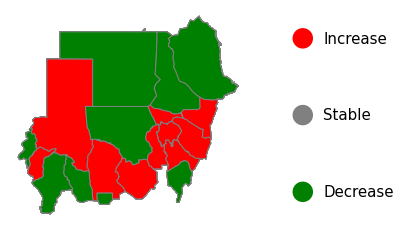

In [49]:
row_count = len(color_dict)#shapefile["change_name"].nunique()
ax_list = []
for i in range(row_count+1):
    ax_list.append("ax" + str(i+1))
ax_string = ", ".join(ax_list)
# print(ax_string)
fig, (ax_string) = plt.subplots(row_count, 4)#figsize=(10,10)
ax1 = plt.subplot2grid((row_count,4),(0,0), rowspan=row_count, colspan=3)
for index, row in bucky_npi_sel.iterrows():
    plot = shapefile[shapefile["change_name"] == row["change_name"]].plot(color=color_dict[row["change_name"]], ax=ax1,legend=False,edgecolor='gray')
    ax1.axis("off")
    
row_counter = 0
for i in color_dict.keys(): 
    plt.subplot2grid((row_count,4),(row_counter,3))
    plt.pie([1],labels=[i],radius=0.4, colors=[color_dict[i]],labeldistance=-2)
    plt.axis("off")
    row_counter += 1

In [90]:
# def create_change_map(country_iso3, parameters):
#     # Total cases - four weeks projection
#     color_dict={"Increase":"red","Stable":"grey","Decrease":"green"}
#     bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
#     bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
#     bucky_npi_change=bucky_npi.loc[bucky_npi.index.isin([TODAY,TWO_WEEKS]),:].groupby("adm1")["cases_per_100k"].pct_change().replace(np.nan,0)
#     bucky_npi_ct=bucky_npi_change[TWO_WEEKS]
#     bucky_npi_sel=bucky_npi.loc[TWO_WEEKS,:]
#     bucky_npi_sel.loc[:,"change_cases_100k"]=bucky_npi_ct.values
#     bucky_npi_sel.loc[:,"change_name"]=bucky_npi_sel["change_cases_100k"].apply(lambda x: "Increase" if x>0.05 else ("Decrease" if x<0.05 else "Stable"))
#     adm1_pcode_prefix=parameters['iso2_code']
#     if country_iso3 == 'IRQ':
#         adm1_pcode_prefix='IQG'
#     bucky_npi_sel.loc[:,'adm1']=adm1_pcode_prefix + bucky_npi_sel['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
#     shapefile = gpd.read_file(parameters['shape'])
#     shapefile = shapefile.merge(bucky_npi_sel, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
    
#     row_count = len(color_dict)#shapefile["change_name"].nunique()
#     ax_list = []
#     for i in range(row_count+1):
#         ax_list.append("ax" + str(i+1))
#     ax_string = ", ".join(ax_list)
#     # print(ax_string)
#     fig, (ax_string) = plt.subplots(row_count, 4)#figsize=(10,10)
#     ax1 = plt.subplot2grid((row_count,4),(0,0), rowspan=row_count, colspan=3)
#     for index, row in bucky_npi_sel.iterrows():
#         plot = shapefile[shapefile["change_name"] == row["change_name"]].plot(color=color_dict[row["change_name"]], ax=ax1,legend=False,edgecolor='gray')
#         ax1.axis("off")
#     row_counter = 0
#     for i in color_dict.keys(): 
#         plt.subplot2grid((row_count,4),(row_counter,3))
#         plt.pie([1],labels=[i],radius=0.4, colors=[color_dict[i]],labeldistance=-2)
#         plt.axis("off")
#         row_counter += 1
        
#     # create simple linear colormap that maps grey to blue
# #     cmap = LinearSegmentedColormap.from_list('mycmap', [("increase", 'red'), ("decrease", 'green'),("constant","grey")])
#     fig_title=f'Projected trend in number of cases per 100,000 people'
#     # fig_title=f'Ranking: number of cases per 100,000 people on {TWO_WEEKS}'
# #     fig,axis=create_new_subplot(fig_title)
# #     axis.axis('off')
# #     shapefile.plot(column='change_name', figsize=(10, 10),edgecolor='gray',ax=axis, categorical=True,
# #                    legend=True, color=["red","green"]
# #                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
# # #                    scheme='Quantiles',k=len(shapefile)
# #                    )
#     shapefile.boundary.plot(linewidth=0.1,ax=ax1)

In [441]:
def calculate_subnational_trends(country_iso3, parameters):
    # Top 5 and bottom 5 districts - 4 weeks trend
    bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
    # to remove noise
    bucky_npi=bucky_npi[bucky_npi['cases_active']>1]
    bucky_npi["little"]=np.where(bucky_npi.cases_active<10,"True","False")
    bucky_npi = bucky_npi.loc[bucky_npi['q']==0.5,['adm1','Reff','cases_per_100k',"cases_active","little"]]
#     display(bucky_npi)
    adm1_pcode_prefix=parameters['iso2_code']
    if country_iso3 == 'IRQ':
        adm1_pcode_prefix='IQG'
    bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
#     print("k",len(bucky_npi.loc[bucky_npi.index.isin([TODAY,TWO_WEEKS]),:]))
    #make the col selector a list to ensure always a dataframe is returned (and not a series)
    start = bucky_npi.loc[[TODAY],:]
    end = bucky_npi.loc[[TWO_WEEKS],:]
#     display(start)
#     display(end)
#     print(len(start))
#     print(len(end))
    combined = start.merge(end[['adm1', 'cases_per_100k',"cases_active","little"]], how='left', on='adm1')
#     display(combined)
    combined.rename(columns = {'cases_per_100k_x':'cases_per_100k_today', 'cases_per_100k_y':'cases_per_100k_inTWOweeks'}, inplace = True) 
    combined['cases_per_100k_change'] = (combined['cases_per_100k_inTWOweeks']-combined['cases_per_100k_today']) / combined['cases_per_100k_today'] * 100
    shapefile = gpd.read_file(parameters['shape'])
    shapefile=shapefile[[parameters['adm1_pcode'],parameters['adm1_name']]]
    combined=combined.merge(shapefile,how='left',left_on='adm1',right_on=parameters['adm1_pcode'])
    combined = combined.sort_values('cases_per_100k_change', ascending=False)
    
    combined=combined.dropna()
#     display(combined)
    combined['cases_per_100k_change']=combined['cases_per_100k_change'].astype(int)
    # combined=combined[[parameters['adm1_name'],'cases_per_100k_change']]
#     combined.to_csv(f'Outputs/{country_iso3}/ADM1_ranking.csv', index=False)
    return combined

In [442]:
def get_change_diff(country_iso3,parameters):
    bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
    bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
    bucky_npi_change=bucky_npi.loc[bucky_npi.index.isin([TODAY,TWO_WEEKS]),:].groupby("adm1")["cases_per_100k"].pct_change().replace(np.nan,0)
    bucky_npi_ct=bucky_npi_change[TWO_WEEKS]
    bucky_npi_sel=bucky_npi.loc[TWO_WEEKS,:]
    print("a",len(bucky_npi.loc[bucky_npi.index.isin([TODAY,TWO_WEEKS]),:]))
    print("b",len(bucky_npi_ct))
    print("s",len(bucky_npi_sel))
    bucky_npi_sel.loc[:,"change_cases_100k"]=bucky_npi_ct.values
    bucky_npi_sel.loc[:,"change_name"]=bucky_npi_sel["change_cases_100k"].apply(lambda x: "Increase" if x>0.05 else ("Decrease" if x<0.05 else "Stable"))
    adm1_pcode_prefix=parameters['iso2_code']
    if country_iso3 == 'IRQ':
        adm1_pcode_prefix='IQG'
    bucky_npi_sel.loc[:,'adm1']=adm1_pcode_prefix + bucky_npi_sel['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
    shapefile = gpd.read_file(parameters['shape'])
    shapefile = shapefile.merge(bucky_npi_sel, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
    return shapefile

In [443]:
# def create_change_map(country_iso3, parameters):
#     # Total cases - four weeks projection
#     color_dict={"Increase":"red","Stable":"grey","Decrease":"green"}
#     df_change=calculate_subnational_trends(country_iso3,parameters)
#     df_change=df_change.drop_duplicates()
# #     display(df_change)
# #     display(df_change)
# #     bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
# #     bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
# #     bucky_npi_change=bucky_npi.loc[bucky_npi.index.isin([TODAY,TWO_WEEKS]),:].groupby("adm1")["cases_per_100k"].pct_change().replace(np.nan,0)
# #     bucky_npi_ct=bucky_npi_change[TWO_WEEKS]
# #     bucky_npi_sel=bucky_npi.loc[TWO_WEEKS,:]
# #     bucky_npi_sel.loc[:,"change_cases_100k"]=bucky_npi_ct.values
# #     bucky_npi_sel.loc[:,"change_name"]=bucky_npi_sel["change_cases_100k"].apply(lambda x: "Increase" if x>0.05 else ("Decrease" if x<0.05 else "Stable"))
# #     adm1_pcode_prefix=parameters['iso2_code']
# #     if country_iso3 == 'IRQ':
# #         adm1_pcode_prefix='IQG'
# #     bucky_npi_sel.loc[:,'adm1']=adm1_pcode_prefix + bucky_npi_sel['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
#     shapefile = gpd.read_file(parameters['shape'])
#     shapefile = shapefile.merge(df_change, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
#     shapefile.loc[:,"change_name"]=shapefile["cases_per_100k_change"].apply(lambda x: "Increase" if x>=5 else ("Decrease" if x<=-5 else "Stable"))
# #     print("blub")
#     #     display(shapefile[["adm1","cases_per_100k_change"]])
#     row_count = len(color_dict)+1#shapefile["change_name"].nunique()
#     ax_list = []
#     for i in range(row_count+1):
#         ax_list.append("ax" + str(i+1))
#     ax_string = ", ".join(ax_list)
#     # print(ax_string)
#     fig, (ax_string) = plt.subplots(row_count, 4)#figsize=(10,10)
#     ax1 = plt.subplot2grid((row_count,4),(0,0), rowspan=row_count, colspan=3)
# #     
#     for k in shapefile["change_name"].unique():
#         plot=shapefile[shapefile["change_name"]==k].plot(color=color_dict[k], ax=ax1,legend=False,edgecolor='gray')
# #     for index, row in shapefile.iterrows():
# #         plot = shapefile[shapefile["change_name"] == row["change_name"]].plot(color=color_dict[row["change_name"]], ax=ax1,legend=False,edgecolor='gray')
#         ax1.axis("off")
#     plt.subplot2grid((row_count,4),(0,3))
#     plt.text("bla")
#     row_counter = 1
#     for i in color_dict.keys(): 
#         plt.subplot2grid((row_count,4),(row_counter,3))
#         plt.pie([1],labels=[i],radius=0.4, colors=[color_dict[i]],labeldistance=-2)
#         plt.axis("off")
#         row_counter += 1
        
#     # create simple linear colormap that maps grey to blue
# #     cmap = LinearSegmentedColormap.from_list('mycmap', [("increase", 'red'), ("decrease", 'green'),("constant","grey")])
#     fig_title=f'Projected trend in number of cases per 100,000 people'
#     # fig_title=f'Ranking: number of cases per 100,000 people on {TWO_WEEKS}'
# #     fig,axis=create_new_subplot(fig_title)
# #     axis.axis('off')
# #     shapefile.plot(column='change_name', figsize=(10, 10),edgecolor='gray',ax=axis, categorical=True,
# #                    legend=True, color=["red","green"]
# #                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
# # #                    scheme='Quantiles',k=len(shapefile)
# #                    )
#     shapefile.boundary.plot(linewidth=0.1,ax=ax1,color="white")

In [444]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [445]:
def create_change_map(country_iso3, parameters):
    # Total cases - four weeks projection
    color_dict={"Increase":"red","Stable":"grey","Decrease":"green"}
    df_change=calculate_subnational_trends(country_iso3,parameters)
    display(df_change)
    shapefile = gpd.read_file(parameters['shape'])
    shapefile = shapefile.merge(df_change, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
    shapefile.loc[:,"change_name"]=shapefile["cases_per_100k_change"].apply(lambda x: "Increase" if x>=5 else ("Decrease" if x<=-5 else "Stable"))
    fig_title=f'Projected trend in number of cases per 100,000 people'
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(fig_title)
    for k in shapefile["change_name"].unique():
        shapefile[shapefile["change_name"]==k].plot(color=color_dict[k], ax=ax,edgecolor='gray')
    legend_elements= [Line2D([0], [0], marker='o',markersize=15,label=k,color=color_dict[k],linestyle='None') for k in color_dict.keys()]
    leg=plt.legend(title="Legend",frameon=False,handles=legend_elements,bbox_to_anchor=(1.3,0.8))
    leg._legend_box.align = "left"
#     [mpatches.Patch(color=color_dict[k], label=k) for k in color_dict.keys()]

    shapefile.boundary.plot(linewidth=0.1,ax=ax,color="white")
    ax.set_axis_off()


,adm1,Reff,cases_per_100k_today,cases_active_x,little_x,cases_per_100k_inTWOweeks,cases_active_y,little_y,cases_per_100k_change,ADM1_PCODE,ADM1_EN
0,SS01,1.013801,8.575027,107.147,False,7.135639,89.1615,False,-16,SS01,Central Equatoria


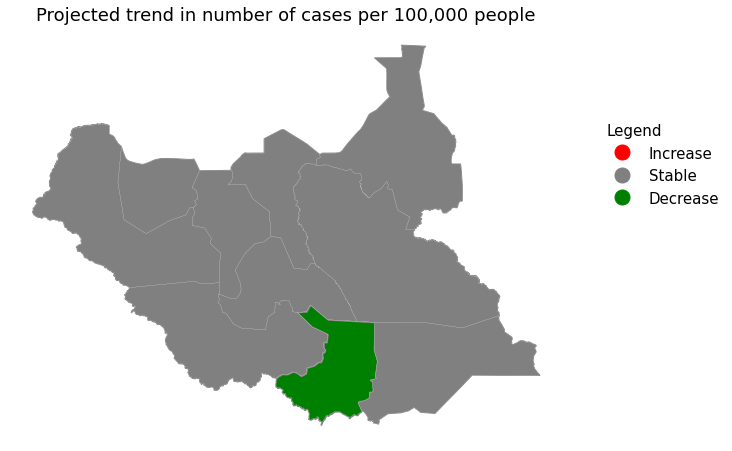

In [446]:
for country_iso3 in ["SSD"]:#["SDN","AFG", "SSD", "COD", "SOM", "IRQ"]:
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    create_change_map(country_iso3,parameters)

In [343]:
# from matplotlib.patches import Patch
# from matplotlib.lines import Line2D
# color_dict={"Increase":"red","Stable":"grey","Decrease":"green"}
# # legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
# #                    Line2D([0], [0], marker='o', color='w', label='Scatter',
# #                           markerfacecolor='g', markersize=15),
# #                    Patch(facecolor='orange', edgecolor='r',
# #                          label='Color Patch')]

# legend_elements= [Line2D([0], [0], marker='o',markersize=15,label=k,color=color_dict[k],linestyle='None') for k in color_dict.keys()]

# # Create the figure
# fig, ax = plt.subplots()
# ax.legend(handles=legend_elements, loc='center')

# plt.show()

Legend editing links:
- https://gis.stackexchange.com/questions/281949/how-to-define-boundary-numbers-without-decimal-points-geopandas
- https://matplotlib.org/gallery/text_labels_and_annotations/custom_legends.html

In [321]:
hist_data=get_who(WHO_COVID_FILENAME,parameters['iso2_code'],min_date=pd.to_datetime('2000-01-01'),max_date=FOUR_WEEKS)

In [322]:
hist_data

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,
2020-01-03,IQ,Iraq,EMRO,0,0,0,0
2020-01-04,IQ,Iraq,EMRO,0,0,0,0
2020-01-05,IQ,Iraq,EMRO,0,0,0,0
2020-01-06,IQ,Iraq,EMRO,0,0,0,0
2020-01-07,IQ,Iraq,EMRO,0,0,0,0
...,...,...,...,...,...,...,...
2020-09-19,IQ,Iraq,EMRO,4305,311690,76,8408
2020-09-20,IQ,Iraq,EMRO,3907,315597,83,8491
2020-09-21,IQ,Iraq,EMRO,3438,319035,64,8555


In [323]:
import numpy as np
import matplotlib.colors as mcolors

In [348]:
# def create_subnational_map(country_iso3, parameters):
#     # Total cases - four weeks projection
#     parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
#     bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
#     bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
#     bucky_npi = bucky_npi.loc[TWO_WEEKS,:]
#     adm1_pcode_prefix=parameters['iso2_code']
#     if country_iso3 == 'IRQ':
#         adm1_pcode_prefix='IQG'
#     bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
#     bucky_npi["cases_per_100k"]=bucky_npi["cases_per_100k"].astype(int)
#     shapefile = gpd.read_file(parameters['shape'])
#     shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
#     fig_title=f'{country_iso3}: Projected number of cases per 100,000 people'
#     # fig_title=f'Ranking: number of cases per 100,000 people on {TWO_WEEKS}'
#     fig,axis=create_new_subplot(fig_title)
#     axis.axis('off')
    
#     hist_bucky=get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY-timedelta(days=90),max_date=TODAY,npi_filter='npi')
#     hist_bucky["cases_per_100k"]=hist_bucky["cases_per_100k"].astype(int)
#     hist_buckys=hist_bucky[hist_bucky['q']==0.5]
#     cases_max=hist_buckys["cases_per_100k"].max()
# #     cases_min=hist_bucky["cases_per_100k"].min()
#     scheme="UserDefined"#'quantiles'
#     num_colors=5#min(5,len(bucky_npi.cases_per_100k.unique()))
#     cmap="YlOrRd"#"viridis"#"YlOrRd"#"viridis"
# #     bins_list=[0,10,50,70,200,300,400,600,900,1200,1700,2400,5000] 
# #     shapefile["cases_per_100k"]=shapefile["cases_per_100k"].astype(int)
# #     max_cases=shapefile["cases_per_100k"].max()
# #     max_bin=next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)
# #     bins_listc=bins_list[:1+next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)]
# #     print(bins_listc)
#     print(cases_max)
#     bins_list=np.linspace(0,cases_max*1.2,num_colors+1,dtype=int)
# #     bins_list=mc.EqualInterval([0,cases_max*1.2], k=5)
# #     bins_list=mc.EqualInterval(bucky_npi.cases_per_100k, k=5)
# # q10 = mapclassify.Quantiles(gdf.SIDR79,k=10)
#     print(bins_list)
#     print(bucky_npi.cases_per_100k.unique())
# #     shapefile.plot(column='cases_per_100k',ax=axis,cmap='OrRd',legend_kwds={"title":"bla"},legend=True
# # #                       legend_kwds={'orientation': "horizontal"}
# #                    )
# #,missing_kwds={"color":"lightgrey"}) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
# #                 #    legend=True,
# #     shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap
# #                    ,scheme=scheme, legend=True, legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75)),
# #             classification_kwds=dict(bins=bins_list)#,orientation="horizontal")

# # )
    
# #     shapefile.assign(cl=UserDefined(shapefile["cases_per_100k"].dropna(), bins_list)).plot(
# #     column='cl', ax=ax1, cmap='OrRd'
# # )
#     norm2 = mcolors.BoundaryNorm(boundaries=bins_list, ncolors=256) 
#     shapefile.plot(column='cases_per_100k', cmap="YlOrRd", norm=norm2,ax=axis)
#     fig.colorbar(axis.collections[0], cax = fig.add_axes([0.9, 0.2, 0.03, 0.60]))
    
# #     shapefile.assign(cl=UserDefined(shapefile['cases_per_100k'].dropna(), bins_list).yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True)
# #     shapefile.assign(cl=bins_list.yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True) #categorical=True,
# #     shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap, legend=True
# #                ,scheme=scheme,
# #          legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75), title="Legend\n", frameon=False),
# #         classification_kwds=dict(bins=bins_list)#)#,orientation="horizontal")

# #     )
# #     fig.colorbar(axis.collections[0], ax=axis)
# #     shapefile.plot(column='cases_per_100k', figsize=(10, 10),edgecolor='gray',ax=axis,
# #                    legend=True,
# #                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
# #                    scheme='Quantiles',k=len(shapefile)
# #                    )
# #     print(shapefile.cases_per_100k.value_counts())
#     vmin = shapefile.cases_per_100k.min()
#     vmax = shapefile.cases_per_100k.max()
    
# #     cax = fig.add_axes([0.1, 0.1, 0.8,0.03])
# # #     cax = fig.add_axes([1, 0.1, 0.03, 0.8])
# #     sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
# #     sm._A = []
# #     cbr = fig.colorbar(sm, cax=cax, orientation="horizontal")
# #     shapefile.boundary.plot(linewidth=0.1,ax=axis)
# #     fig.savefig(f'Outputs/{country_iso3}/map_cases_per_100k_2w.png')

# #     leg = axis.get_legend()
# # #     print(max_bin)
# #     for lbl in leg.get_texts():
# #         label_text = lbl.get_text()
# #     #                 print(label_text)
# # #         print(label_text)
# #         upper = label_text.split(",")[-1].rstrip(']')

# # #         print("f",upper)
# #         if int(float(upper)) > bins_listc[-1]:
# # #             print("blub")
# #             new_text = f'_'
# #         else:
# #             new_text=label_text
# #         lbl.set_text(new_text)
#     plt.show()

In [449]:
def create_subnational_map(country_iso3, parameters):
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
    bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
    bucky_npi = bucky_npi.loc[TWO_WEEKS,:]
    adm1_pcode_prefix=parameters['iso2_code']
    if country_iso3 == 'IRQ':
        adm1_pcode_prefix='IQG'
    bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
    bucky_npi["cases_per_100k"]=bucky_npi["cases_per_100k"].astype(int)
    shapefile = gpd.read_file(parameters['shape'])
    shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
    
    fig_title=f'Projected number of cases per 100,000 people on {TWO_WEEKS}'
    fig,axis=create_new_subplot(fig_title)
    axis.axis('off')
    
    #get historical max value. Using this instead of current to keep bins over the weeks more equal
    #if patterns change heavily, could also choose to set min_date to e.g. TODAY-timedelta(days=90)
    hist_bucky=get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY-timedelta(days=90),max_date=FOUR_WEEKS,npi_filter='npi')
    hist_buckys=hist_bucky[hist_bucky['q']==0.5]
    cases_max=hist_buckys["cases_per_100k"].astype(int).max()
    scheme="UserDefined"
    num_bins=5
    cmap="YlOrRd"
    bins_list=np.linspace(0,cases_max*1.2,num_bins+1,dtype=int)

    #set bins
    norm2 = mcolors.BoundaryNorm(boundaries=bins_list, ncolors=256) 
    shapefile.plot(column='cases_per_100k', cmap="YlOrRd", norm=norm2,ax=axis)
    fig.colorbar(axis.collections[0], cax = fig.add_axes([0.9, 0.2, 0.03, 0.60]))

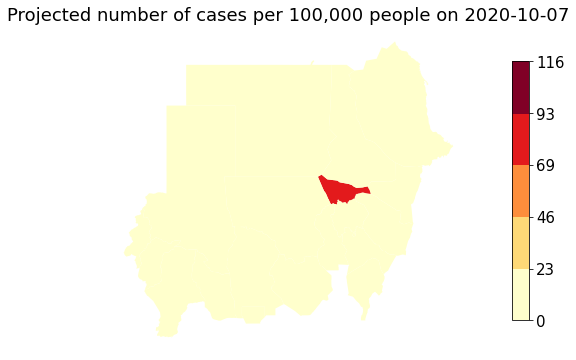

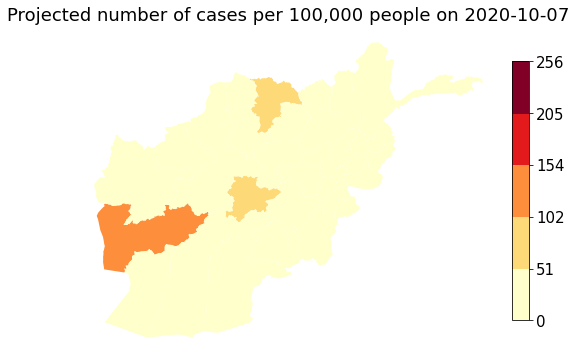

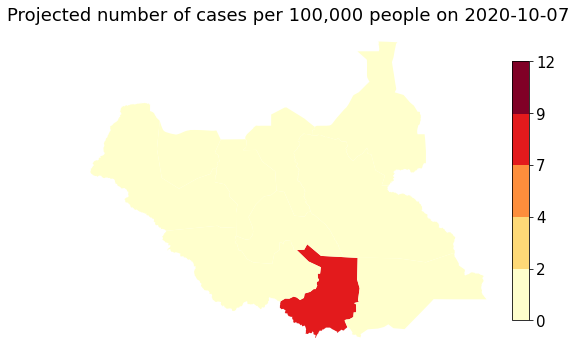

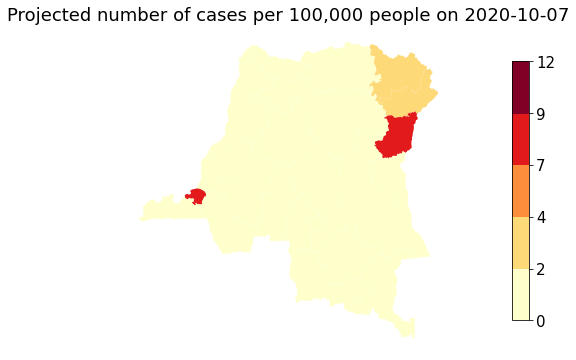

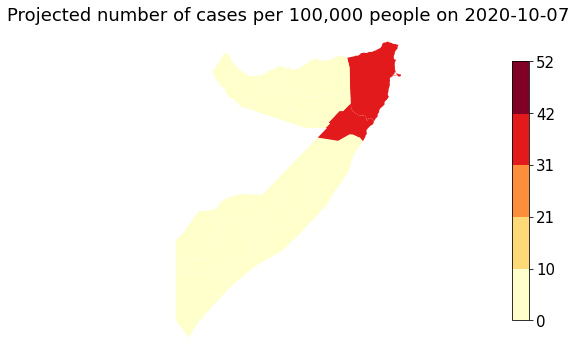

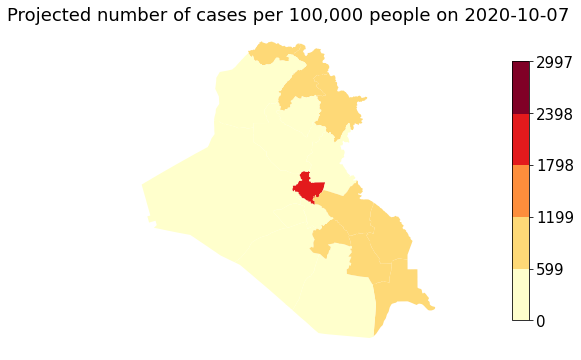

In [450]:
for country_iso3 in ["SDN","AFG", "SSD", "COD", "SOM", "IRQ"]:
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    create_subnational_map(country_iso3,parameters)

In [453]:
def create_subnational_map_current(country_iso3, parameters):
    bucky_npi = get_bucky(country_iso3, admin_level='adm1', min_date=TODAY, max_date=TODAY, npi_filter='npi')
    bucky_npi = bucky_npi[bucky_npi['q'] == 0.5][['adm1', 'cases_per_100k']]
    adm1_pcode_prefix = parameters['iso2_code']
    if country_iso3 == 'IRQ':
        adm1_pcode_prefix = 'IQG'
    bucky_npi['adm1'] = adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x: "{0:0=2d}".format(int(x)))
    bucky_npi["cases_per_100k"] = bucky_npi["cases_per_100k"].astype(int)
    shapefile = gpd.read_file(parameters['shape'])
    shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')

    fig_title = f'Number of cases per 100,000 people on {TODAY}'
    fig, axis = create_new_subplot(fig_title)
    axis.axis('off')

    # get historical max value. Using this instead of current to keep bins over the weeks more equal
    # if patterns change heavily, could also choose to set min_date to a more current date
    hist_bucky = get_bucky(country_iso3, admin_level='adm1', min_date=TODAY - timedelta(days=90), max_date=FOUR_WEEKS,
                           npi_filter='npi')
    hist_buckys = hist_bucky[hist_bucky['q'] == 0.5]
    cases_max = hist_buckys["cases_per_100k"].astype(int).max()
    num_bins = 5
    cmap = "YlOrRd"
    bins_list = np.linspace(0, cases_max * 1.2, num_bins + 1, dtype=int)

    # set bins
    norm2 = mcolors.BoundaryNorm(boundaries=bins_list, ncolors=256)
    shapefile.plot(column='cases_per_100k', cmap=cmap, norm=norm2, ax=axis)
    fig.colorbar(axis.collections[0], cax=fig.add_axes([0.9, 0.2, 0.03, 0.60]))
    shapefile.boundary.plot(linewidth=0.1, ax=axis)
    # fig.tight_layout(pad=3.0)
#     fig.savefig(f'Outputs/{country_iso3}/map_cases_per_100k_2w.png',bbox_inches="tight")

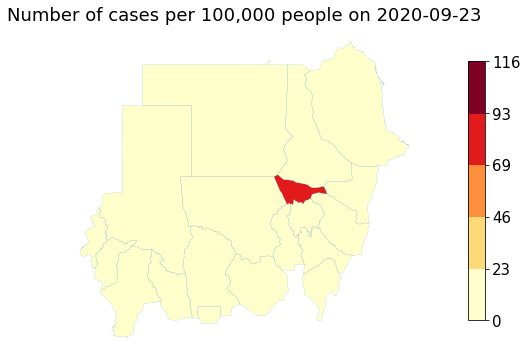

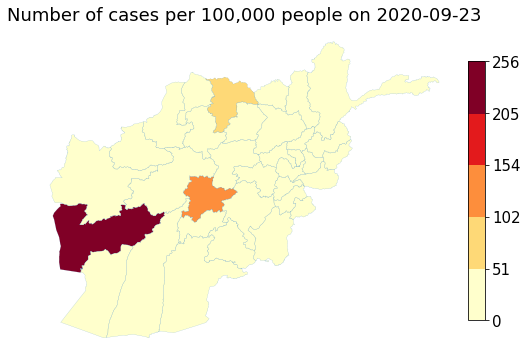

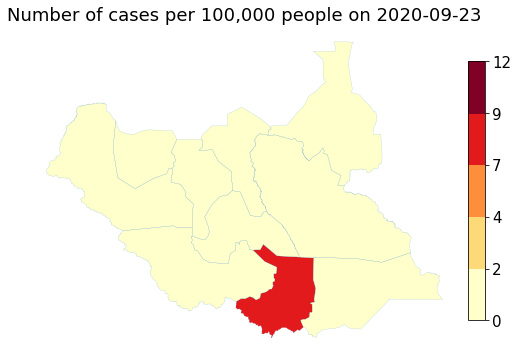

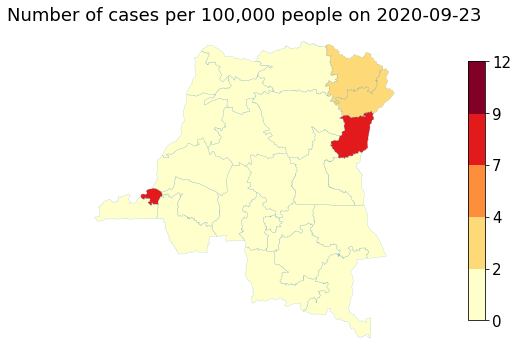

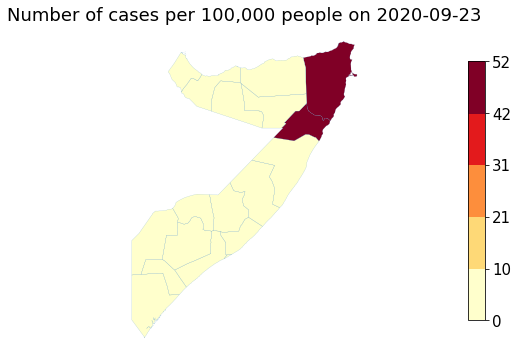

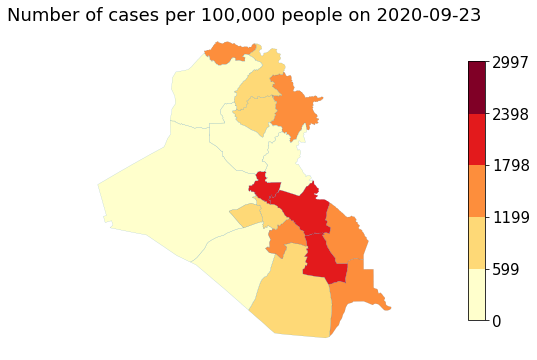

In [454]:
for country_iso3 in ["SDN","AFG", "SSD", "COD", "SOM", "IRQ"]:
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    create_subnational_map_current(country_iso3,parameters)

In [36]:
def create_subnational_map(country_iso3, parameters):
    # Total cases - four weeks projection
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
    bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
    bucky_npi = bucky_npi.loc[TWO_WEEKS,:]
    adm1_pcode_prefix=parameters['iso2_code']
    if country_iso3 == 'IRQ':
        adm1_pcode_prefix='IQG'
    bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
    bucky_npi["cases_per_100k"]=bucky_npi["cases_per_100k"].astype(int)
    shapefile = gpd.read_file(parameters['shape'])
    shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
    fig_title=f'{country_iso3}: Projected number of cases per 100,000 people'
    # fig_title=f'Ranking: number of cases per 100,000 people on {TWO_WEEKS}'
    fig,axis=create_new_subplot(fig_title)
    axis.axis('off')
    
#     hist_bucky=get_bucky(country_iso3 ,admin_level='adm1',min_date=pd.to_datetime('2000-01-01'),max_date=FOUR_WEEKS,npi_filter='npi')
#     hist_bucky["cases_per_100k"]=hist_bucky["cases_per_100k"].astype(int)
#     cases_max=hist_bucky["cases_per_100k"].max()
#     cases_min=hist_bucky["cases_per_100k"].min()
    scheme="UserDefined"#'quantiles'
    num_colors=5#min(5,len(bucky_npi.cases_per_100k.unique()))
    cmap="YlOrRd"#"viridis"#"YlOrRd"#"viridis"
#     bins_list=[0,10,50,70,200,300,400,600,900,1200,1700,2400,5000] 
#     shapefile["cases_per_100k"]=shapefile["cases_per_100k"].astype(int)
#     max_cases=shapefile["cases_per_100k"].max()
#     max_bin=next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)
#     bins_listc=bins_list[:1+next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)]
#     print(bins_listc)
    bins_list=np.linspace(0,cases_max,num_colors+1,dtype=int)
#     bins_list=mc.EqualInterval([0,cases_max*1.2], k=5)
#     bins_list=mc.EqualInterval(bucky_npi.cases_per_100k, k=5)
# q10 = mapclassify.Quantiles(gdf.SIDR79,k=10)
    print(bins_list)
    print(bucky_npi.cases_per_100k.unique())
#     shapefile.plot(column='cases_per_100k',ax=axis,cmap='OrRd',legend_kwds={"title":"bla"},legend=True
# #                       legend_kwds={'orientation': "horizontal"}
#                    )
#,missing_kwds={"color":"lightgrey"}) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#     shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap
#                    ,scheme=scheme, legend=True, legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75)),
#             classification_kwds=dict(bins=bins_list)#,orientation="horizontal")

# )
    
#     shapefile.assign(cl=UserDefined(shapefile["cases_per_100k"].dropna(), bins_list)).plot(
#     column='cl', ax=ax1, cmap='OrRd'
# )
    norm2 = mcolors.BoundaryNorm(boundaries=bins_list, ncolors=256) 
    shapefile.plot(column='cases_per_100k', cmap="YlOrRd", norm=norm2,ax=axis)
    fig.colorbar(axis.collections[0], cax = fig.add_axes([0.9, 0.2, 0.03, 0.60]))
    
#     shapefile.assign(cl=UserDefined(shapefile['cases_per_100k'].dropna(), bins_list).yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True)
#     shapefile.assign(cl=bins_list.yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True) #categorical=True,
#     shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap, legend=True
#                ,scheme=scheme,
#          legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75), title="Legend\n", frameon=False),
#         classification_kwds=dict(bins=bins_list)#)#,orientation="horizontal")

#     )
#     fig.colorbar(axis.collections[0], ax=axis)
#     shapefile.plot(column='cases_per_100k', figsize=(10, 10),edgecolor='gray',ax=axis,
#                    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(shapefile)
#                    )
#     print(shapefile.cases_per_100k.value_counts())
    vmin = shapefile.cases_per_100k.min()
    vmax = shapefile.cases_per_100k.max()
    
#     cax = fig.add_axes([0.1, 0.1, 0.8,0.03])
# #     cax = fig.add_axes([1, 0.1, 0.03, 0.8])
#     sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     sm._A = []
#     cbr = fig.colorbar(sm, cax=cax, orientation="horizontal")
#     shapefile.boundary.plot(linewidth=0.1,ax=axis)
#     fig.savefig(f'Outputs/{country_iso3}/map_cases_per_100k_2w.png')

#     leg = axis.get_legend()
# #     print(max_bin)
#     for lbl in leg.get_texts():
#         label_text = lbl.get_text()
#     #                 print(label_text)
# #         print(label_text)
#         upper = label_text.split(",")[-1].rstrip(']')

# #         print("f",upper)
#         if int(float(upper)) > bins_listc[-1]:
# #             print("blub")
#             new_text = f'_'
#         else:
#             new_text=label_text
#         lbl.set_text(new_text)
    plt.show()

In [37]:
# bins = Quantiles(pop_gdf['central_pop'], 5).bins


# pop_gdf.assign(cl=User_Defined(pop_gdf['low_pop'].dropna(), bins).yb).plot(
#     column='cl', ax=ax1, cmap='OrRd'
# )
# pop_gdf.plot('central_pop', scheme='quantiles',  ax=ax2, cmap='OrRd', legend=True, cax=ax3,
#              legend_kwds=dict(loc='upper right', bbox_to_anchor=(3.5, 0.75), title="Legend\n", frameon=False)

# )
# pop_gdf.assign(cl=User_Defined(pop_gdf['high_pop'].dropna(), list(bins)).yb).plot(
#     column='cl', ax=ax3, cmap='OrRd', legend=False
# )

In [87]:
country_iso3="IRQ"
parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=pd.to_datetime('2000-01-01'),max_date=FOUR_WEEKS,npi_filter='npi')
print(bucky_npi.index.unique())
bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
bucky_npit=bucky_npi.loc[TODAY]
bucky_npi = bucky_npi.loc[TWO_WEEKS]
print(bucky_npi.index.unique())
adm1_pcode_prefix=parameters['iso2_code']
if country_iso3 == 'IRQ':
    adm1_pcode_prefix='IQG'
bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
shapefile = gpd.read_file(parameters['shape'])
shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')

Index([2020-09-08, 2020-09-09, 2020-09-10, 2020-09-11, 2020-09-12, 2020-09-13,
       2020-09-14, 2020-09-15, 2020-09-16, 2020-09-17, 2020-09-18, 2020-09-19,
       2020-09-20, 2020-09-21, 2020-09-22, 2020-09-23, 2020-09-24, 2020-09-25,
       2020-09-26, 2020-09-27, 2020-09-28, 2020-09-29, 2020-09-30, 2020-10-01,
       2020-10-02, 2020-10-03, 2020-10-04, 2020-10-05, 2020-10-06, 2020-10-07],
      dtype='object', name='date')
Index([2020-09-23], dtype='object', name='date')


In [90]:
bucky_npit

,adm1,cases_per_100k
date,,
2020-09-09,1.0,222.309227
2020-09-09,2.0,1193.741280
2020-09-09,3.0,2845.523091
2020-09-09,4.0,971.959182
2020-09-09,5.0,1830.692858
2020-09-09,6.0,1506.647664
2020-09-09,7.0,716.863449
2020-09-09,8.0,2421.012391
2020-09-09,9.0,1552.444919


In [88]:
bucky_npi

,adm1,cases_per_100k
date,,
2020-09-23,IQG01,340.184676
2020-09-23,IQG02,715.187251
2020-09-23,IQG03,1416.965672
2020-09-23,IQG04,707.544013
2020-09-23,IQG05,1056.321402
2020-09-23,IQG06,736.488989
2020-09-23,IQG07,493.018361
2020-09-23,IQG08,2251.278366
2020-09-23,IQG09,1364.043225


In [89]:
bucky_npi["prev"]=bucky_npit.loc[bucky_npi.adm1==bucky_npit.adm1,"cases_per_100k"]

ValueError: Can only compare identically-labeled Series objects

In [71]:
b=get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY-timedelta(days=90),max_date=TWO_WEEKS,npi_filter='npi')

In [82]:
b

,adm1,q,cases_asymptomatic_active,cumulative_deaths,daily_cases,daily_cases_reported,daily_deaths,cumulative_cases,cumulative_cases_reported,ICU,VENT,CASE_REPORT,Reff,doubling_t,N,cases_active,hospitalizations,cases_per_100k
date,,,,,,,,,,,,,,,,,,
2020-09-08,1.0,0.05,598.47440,63.99900,-1373.01100,-56.65795,0.00000,49599.31130,3420.34200,9.32950,6.27140,0.029,1.100987,29.431012,1854583.386,2542.59380,38.89395,137.097842
2020-09-08,1.0,0.25,1096.43700,63.99900,-834.25725,-37.08425,0.00000,62031.61400,3439.91550,13.99475,10.19075,0.038,1.120241,35.406570,1854583.388,3365.04650,54.69000,181.444874
2020-09-08,1.0,0.50,1474.70900,63.99900,-561.01500,-26.02400,0.00000,74290.33000,3450.97600,18.61750,13.79400,0.046,1.135411,39.626553,1854583.389,4231.78850,71.41800,228.180007
2020-09-08,1.0,0.75,2011.24925,63.99900,-345.28725,-16.40825,0.00000,89704.82150,3460.59200,24.82600,18.52925,0.056,1.157123,43.700304,1854583.390,5320.22150,92.31575,286.868821
2020-09-08,1.0,0.95,2975.07285,63.99900,-143.04165,-7.31245,0.00000,119394.17585,3469.68660,36.46010,28.16595,0.070,1.218390,49.868717,1854583.392,7392.24500,131.04690,398.593292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,18.0,0.05,3445.81885,352.44605,1158.45895,66.50155,2.49785,178458.68735,16324.52905,37.37770,25.45160,0.042,1.101198,30.114601,1384280.874,8041.37290,160.55675,580.906162
2020-09-23,18.0,0.25,5684.10850,370.52450,1523.13500,93.79575,3.28400,219798.04700,16896.66825,56.79275,39.80025,0.056,1.119293,35.878923,1384280.876,11780.64000,234.85325,851.029600
2020-09-23,18.0,0.50,7615.58450,384.83800,1806.49300,120.87600,3.93050,259641.53100,17378.66200,74.40850,53.97800,0.067,1.134589,39.768911,1384280.877,15046.86700,299.63700,1086.980775


In [72]:
b.q.value_counts()

0.05    288
0.95    288
0.75    288
0.50    288
0.25    288
Name: q, dtype: int64

In [73]:
b.index.value_counts()

2020-09-09    90
2020-09-10    90
2020-09-11    90
2020-09-13    90
2020-09-23    90
2020-09-15    90
2020-09-19    90
2020-09-18    90
2020-09-22    90
2020-09-16    90
2020-09-14    90
2020-09-21    90
2020-09-20    90
2020-09-12    90
2020-09-08    90
2020-09-17    90
Name: date, dtype: int64

In [74]:
b[b.q==0.5]

,adm1,q,cases_asymptomatic_active,cumulative_deaths,daily_cases,daily_cases_reported,daily_deaths,cumulative_cases,cumulative_cases_reported,ICU,VENT,CASE_REPORT,Reff,doubling_t,N,cases_active,hospitalizations,cases_per_100k
date,,,,,,,,,,,,,,,,,,
2020-09-08,1.0,0.5,1474.7090,63.9990,-561.0150,-26.0240,0.0000,74290.3300,3450.9760,18.6175,13.7940,0.046,1.135411,39.626553,1854583.389,4231.7885,71.4180,228.180007
2020-09-09,1.0,0.5,1518.3740,65.2540,485.2250,22.6575,1.2510,74724.7505,3473.4920,18.5055,13.5960,0.046,1.135411,39.626553,1854583.390,4122.9100,69.9460,222.309227
2020-09-10,1.0,0.5,1606.7170,66.4175,577.1365,26.6320,1.1650,75242.9405,3501.4430,18.6685,13.8485,0.046,1.135411,39.626553,1854583.390,4060.1210,70.4255,218.923615
2020-09-11,1.0,0.5,1739.4650,67.5440,661.1610,29.9075,1.0810,75872.9630,3532.7370,19.3085,14.4990,0.046,1.135411,39.626553,1854583.390,4107.3485,73.4840,221.470144
2020-09-12,1.0,0.5,1878.6175,68.5820,712.1675,32.4445,1.0485,76617.1040,3565.1955,20.2825,15.1950,0.046,1.135411,39.626553,1854583.390,4225.8015,77.0910,227.857185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-19,18.0,0.5,8542.2205,366.4985,1980.1120,133.7450,5.2550,251919.2425,16863.6895,89.1590,65.2235,0.067,1.134419,39.768911,1384280.877,17422.3255,348.6645,1258.583124
2020-09-20,18.0,0.5,8288.0470,371.5145,1934.9890,130.1405,4.8680,253872.1575,16995.4375,85.4440,61.5755,0.067,1.134419,39.768911,1384280.877,16819.3750,334.8365,1215.026176
2020-09-21,18.0,0.5,8062.6255,375.9365,1895.6250,127.1360,4.5440,255761.2780,17122.3575,81.9985,58.8035,0.067,1.134419,39.768911,1384280.877,16180.0155,321.3350,1168.839053


In [177]:
# shapefile.ADM0_EN.unique()

In [178]:
print(f"Number of occurences for {country_iso3}")
cases_count=pd.DataFrame(shapefile.cases_per_100k.astype(int).value_counts().sort_index())
cases_count.index=cases_count.index.rename("Cases per 100k")
cases_count.columns=["Occurences"]
cases_count

Number of occurences for IRQ


,Occurences
Cases per 100k,
340,7
493,4
612,9
694,7
699,6
707,3
715,7
736,10
798,6


In [157]:
sorted(shapefile.cases_per_100k.astype(int).unique())

[0, 2, 3, 4, 5, 9, 10, 11, 12, 13, 21, 25, 36, 41, 59, 65]

In [138]:
bins_list=[0,70,200,300,400,600,900,1200,1700,2400,5000] 

In [139]:
m=shapefile.cases_per_100k.max()

In [140]:
ni=next(x[0] for x in enumerate(bins_list) if x[1] > m)

In [141]:
bins_list[:ni+1]

[0, 70]

In [142]:
UserDefined(shapefile["cases_per_100k"].astype(int).dropna(), bins_list)

UserDefined               

     Interval        Count
--------------------------
[   0.00,    0.00] |    13
(   0.00,   70.00] |    21
(  70.00,  200.00] |     0
( 200.00,  300.00] |     0
( 300.00,  400.00] |     0
( 400.00,  600.00] |     0
( 600.00,  900.00] |     0
( 900.00, 1200.00] |     0
(1200.00, 1700.00] |     0
(1700.00, 2400.00] |     0
(2400.00, 5000.00] |     0

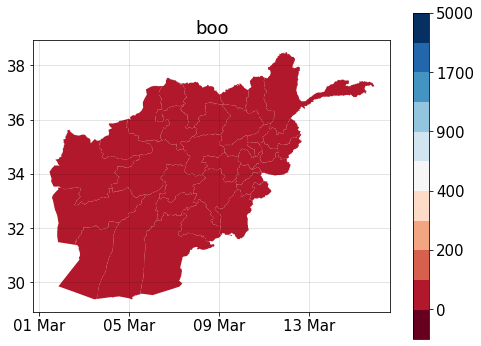

In [148]:
fig,axis=create_new_subplot("boo")
bounds = np.array([-5,0,70,200,300,400,600,900,1200,1700,2400,5000])  #np.array([-0.02, -0.01, 0., 0.01, 0.02, 0.03])
norm2 = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256) 
shapefile.plot(column='cases_per_100k', cmap='RdBu', norm=norm2,ax=axis)
fig.colorbar(axis.collections[0], ax=axis)

In [124]:
shapefile.assign(cl=UserDefined(shapefile["cases_per_100k"].astype(int).dropna(), bins_list))

TypeError: '<' not supported between instances of 'float' and 'str'

In [35]:
shapefile.dtypes

Shape_Leng         float64
Shape_Area         float64
ADM1_EN             object
ADM1_AR             object
ADM1_PCODE          object
ADM1_REF            object
ADM1ALT1EN          object
ADM1ALT2EN          object
ADM1ALT1AR          object
ADM1ALT2AR          object
ADM0_EN             object
ADM0_AR             object
ADM0_PCODE          object
date                object
validOn             object
validTo             object
geometry          geometry
adm1                object
cases_per_100k     float64
dtype: object